<a href="https://colab.research.google.com/github/rdiazrincon/SLEAP_Data/blob/master/analysis/prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning for behavioral prediction of differences in dominant vs subordinate mice during reward competition 

### (Optional) Installing required packages

**Note:** If you are runnning this Notebook from Colab most packages will be already installed. But please do so if you are running locally.

In [1]:
# !pip install h5py
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install sklearn
# !pip install numpy
# !pip install scipy
# !pip install tables

### Importing packages

In [2]:
import h5py
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from scipy.interpolate import interp1d

### Getting the data from Github 

**Note:** Run this if you are using Colab. It will save the labeled data in your current directory.

In [3]:
# !wget -O prediction_analysis.h5 https://github.com/rdiazrincon/SLEAP_Data/blob/master/analysis/data/prediction_analysis.h5

### Setting up the paths for labeled data and reward competition info

In [4]:
path = "data/prediction_analysis.h5"
intervals = "data/WL_info_by_timestamp.csv"

## Exploring the data

In [5]:
# Opening the H5 file
with h5py.File(path, "r") as f:
    dataset_keys = list(f.keys())
    tracks = f["tracks"][:].T
    bodyparts = [n.decode() for n in f["node_names"][:]]

print(f"Filename:{path}")
print(f"Array keys{dataset_keys}:")
print(f"Behavioral data shape:{tracks.shape}")
print(f"Body parts{bodyparts}")

Filename:data/prediction_analysis.h5
Array keys['edge_inds', 'edge_names', 'instance_scores', 'node_names', 'point_scores', 'track_names', 'track_occupancy', 'tracking_scores', 'tracks']:
Behavioral data shape:(54546, 6, 2, 2)
Body parts['left_ear', 'right_ear', 'nose', 'tail_base', 'thorax', 'forehead']


## Understanding the data 

We only work with the tracks array. It contains information regarding Number of Frames, Number of Bodyparts, Number of Coordinates and Number of instances.


In [6]:
# Here's what each dimension of the matrix's shape means
n_frames, n_bodyparts, n_coordinates, n_instances = tracks.shape

print(f"Number of Frames: {n_frames}")
print(f"Number of Bodyparts: {n_bodyparts}")
print(f"Number of Coordinates: {n_coordinates}")
print(f"NUmber of Instances: {n_instances}")

Number of Frames: 54546
Number of Bodyparts: 6
Number of Coordinates: 2
NUmber of Instances: 2


### Exploring (and making sense out of) the data

- The tracks array contains all of the information we need. 
- The first dimension of the array will provide us with information regarding the frames labeled in the video. 
- The second dimension relates to each body part (6 in our case). Note that, in the example below, we get data from the forehead by accesing position 5 in the array. 
- The third dimension relates to the X and Y coordinates and the fourth dimension to the number if animals/mice/instances


#### First frame 

In [7]:
print(tracks[0])

[[[184.44789124 315.60144043]
  [351.55776978 379.87524414]]

 [[140.21481323 284.03588867]
  [364.47213745 367.95025635]]

 [[183.75314331 319.75219727]
  [404.18869019 427.59402466]]

 [[147.53791809 412.41549683]
  [208.04371643 216.35691833]]

 [[148.6204834  339.65484619]
  [324.4312439  299.75323486]]

 [[168.43464661 296.26281738]
  [367.9828186  387.65563965]]]


#### Forehead coordinates for both mouse in Frame 1

**Note:** You can find the forehead data in position 5 of the tracks array. In general, the "bodyparts" array contains information regarding the position of bodyparts.
 

In [8]:
print(tracks[0][5])

[[168.43464661 296.26281738]
 [367.9828186  387.65563965]]


#### Forehead X-coordinate for both mouse in Frame 1

In [9]:
print(tracks[0][5][0])

[168.43464661 296.26281738]


#### Forehead Y-coordinate for mouse 2 in Frame 1.

In [10]:
print(tracks[0][5][0][1]) 

296.2628173828125


## Now let's mess around with the data ...

### Fill-in missing values

We won't drop the NaN values but will fill them with Non Zero values so the analysis is easier to make

In [11]:
def fill_missing(Y, kind="linear"):
    """Fills missing values independently along each dimension after the first."""

    # Store initial shape.
    initial_shape = Y.shape

    # Flatten after first dim.
    Y = Y.reshape((initial_shape[0], -1))

    # Interpolate along each slice.
    for i in range(Y.shape[-1]):
        y = Y[:, i]

        # Build interpolant.
        x = np.flatnonzero(~np.isnan(y))
        f = interp1d(x, y[x], kind=kind, fill_value=np.nan, bounds_error=False)

        # Fill missing
        xq = np.flatnonzero(np.isnan(y))
        y[xq] = f(xq)
        
        # Fill leading or trailing NaNs with the nearest non-NaN values
        mask = np.isnan(y)
        y[mask] = np.interp(np.flatnonzero(mask), np.flatnonzero(~mask), y[~mask])

        # Save slice
        Y[:, i] = y

    # Restore to initial shape.
    Y = Y.reshape(initial_shape)

    return Y

After filling out the NaN values with None Zero values, the array maintains the same shape

In [12]:
tracks = fill_missing(tracks)
print(tracks.shape)

(54546, 6, 2, 2)


### Reading and handling information related to Reward Competition

The information in the Frames column relates to the frames that make up a Trial. We will be reading a file to get this information


In [13]:
df_trials = pd.read_csv(intervals)['Frame']
df_trials

0       2100-2400
1       4470-4770
2       7140-7440
3       9510-9810
4     11730-12030
5     14670-14970
6     17520-17820
7     20160-20460
8     22530-22830
9     25200-25500
10    28140-28440
11    30840-31140
12    34410-34710
13    37050-37350
14    39570-39870
15    42210-42510
16    45030-45330
17    48600-48900
18    50970-51270
19    53790-54090
Name: Frame, dtype: object

### Converting the trials DataFrame to an array

Using the dash to separate each trial in an array

In [14]:
trials_array_separated = [trial.split("-") for trial in df_trials] # Returns a list of lists
print(trials_array_separated)

[['2100', '2400'], ['4470', '4770'], ['7140', '7440'], ['9510', '9810'], ['11730', '12030'], ['14670', '14970'], ['17520', '17820'], ['20160', '20460'], ['22530', '22830'], ['25200', '25500'], ['28140', '28440'], ['30840', '31140'], ['34410', '34710'], ['37050', '37350'], ['39570', '39870'], ['42210', '42510'], ['45030', '45330'], ['48600', '48900'], ['50970', '51270'], ['53790', '54090']]


Looping through the nested array, converting each (str) element to int and appending the elements in a new array 


In [15]:
trials_array = [int(j) for i in range(len(trials_array_separated)) for j in trials_array_separated[i]]
print(trials_array)

# Leaving this here for future reference
# for i in range(len(trials_array_separated)):
#     for j in trials_array_separated[i]:
#         trials_array.append(eval(j))
        
# trials_array

[2100, 2400, 4470, 4770, 7140, 7440, 9510, 9810, 11730, 12030, 14670, 14970, 17520, 17820, 20160, 20460, 22530, 22830, 25200, 25500, 28140, 28440, 30840, 31140, 34410, 34710, 37050, 37350, 39570, 39870, 42210, 42510, 45030, 45330, 48600, 48900, 50970, 51270, 53790, 54090]


## Getting information on mice coordinates based in trials 

For each body part, we loop through the set of frames that comprise a single trial. We repeat for all the trials in the competition (20).
Each video has 30 frames per second(FPS) and each trial lasts 10 second.

In [16]:
LEFT_EAR_INDEX = 0
RIGHT_EAR_INDEX = 1
NOSE_INDEX = 2
TAIL_BASE_INDEX = 3
THORAX_INDEX = 4
FOREHEAD_INDEX = 5

TRIAL_LENGTH_SECONDS = 10
N_TRIALS = 20
FPS = 30

time_window_seconds = 5

frames_per_trial = FPS * TRIAL_LENGTH_SECONDS
time_window_frames = FPS * time_window_seconds

left_ear_loc_aux = []
right_ear_loc_aux = []
nose_loc_aux = []
tail_base_loc_aux = []
thorax_loc_aux = []
forehead_loc_aux = []

Using the onset information to target a different set of frames. Now we are looking at the frames that occur 30 seconds prior to the tone onset and 30 seconds before the tone onset. That is, we will be looking at time_window_frames frames before and after

In [62]:
it = iter(trials_array)
trials_array_onset = []
for i, j in zip(it, it):
    trials_array_onset.append(i - time_window_frames)
    trials_array_onset.append(j)

In [63]:
print(trials_array_onset)

[1950, 2400, 4320, 4770, 6990, 7440, 9360, 9810, 11580, 12030, 14520, 14970, 17370, 17820, 20010, 20460, 22380, 22830, 25050, 25500, 27990, 28440, 30690, 31140, 34260, 34710, 36900, 37350, 39420, 39870, 42060, 42510, 44880, 45330, 48450, 48900, 50820, 51270, 53640, 54090]


In [19]:
print(trials_array)     

[2100, 2400, 4470, 4770, 7140, 7440, 9510, 9810, 11730, 12030, 14670, 14970, 17520, 17820, 20160, 20460, 22530, 22830, 25200, 25500, 28140, 28440, 30840, 31140, 34410, 34710, 37050, 37350, 39570, 39870, 42210, 42510, 45030, 45330, 48600, 48900, 50970, 51270, 53790, 54090]


Using the trials_array to loop through the intervals (first_frame_in_trial:last_frame_in_trial) and fill the vector with the coordinates corresponding for both mice and their body parts  


In [20]:
iterator = iter(trials_array_onset)
for first_frame_in_trial, last_frame_in_trial in zip(iterator, iterator):
    # print(len(tracks[first_frame_in_trial:last_frame_in_trial, RIGHT_EAR_INDEX, :, :]))
    left_ear_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, LEFT_EAR_INDEX, :, :])
    right_ear_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, RIGHT_EAR_INDEX, :, :])
    nose_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, NOSE_INDEX, :, :])
    tail_base_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, TAIL_BASE_INDEX, :, :])
    thorax_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, THORAX_INDEX, :, :])
    forehead_loc_aux.append(tracks[first_frame_in_trial:last_frame_in_trial, FOREHEAD_INDEX, :, :])

frames_in_trial = last_frame_in_trial - first_frame_in_trial

In [21]:
array_shape = np.asarray(left_ear_loc_aux).shape
print(f"Old shape: {array_shape}")
left_ear_loc = np.asarray(left_ear_loc_aux).reshape(N_TRIALS * frames_in_trial , n_coordinates, n_instances)
print(f"New shape: {left_ear_loc.shape}")
right_ear_loc = np.asarray(right_ear_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
nose_loc = np.asarray(nose_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
tail_base_loc = np.asarray(tail_base_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
thorax_loc = np.asarray(thorax_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)
forehead_loc = np.asarray(forehead_loc_aux).reshape(N_TRIALS * frames_in_trial, n_coordinates, n_instances)

Old shape: (20, 450, 2, 2)
New shape: (9000, 2, 2)


### Converting our data into a Tabular format

In [22]:
# There is definitely an easier way of doing this but I don't have the time now

bp = ['left_ear', 'right_ear', 'thorax', 'tail', 'nose']
coord = ['x', 'y']
for i in range(1):
    for j in range(1):
        df_bla = {
            'm{j}_{bp[{0}]}_{i}': left_ear_loc[:, i, j]
        }

df = pd.DataFrame({
    'm1_left_ear_x': left_ear_loc[:, 0, 0], 
    'm1_left_ear_y': left_ear_loc[:, 1, 0], 
    "m2_left_ear_x": left_ear_loc[:, 0, 1],
    "m2_left_ear_y": left_ear_loc[:, 1, 1],

    'm1_right_ear_x': right_ear_loc[:, 0, 0], 
    'm1_right_ear_y': right_ear_loc[:, 1, 0], 
    "m2_right_ear_x": right_ear_loc[:, 0, 1],
    "m2_right_ear_y": right_ear_loc[:, 1, 1],
    
    'm1_nose_x': nose_loc[:, 0, 0], 
    'm1_nose_y': nose_loc[:, 1, 0], 
    "m2_nose_x": nose_loc[:, 0, 1],
    "m2_nose_y": nose_loc[:, 1, 1],

    'm1_tail_base_x': tail_base_loc[:, 0, 0], 
    'm1_tail_base_y': tail_base_loc[:, 1, 0], 
    "m2_tail_base_x": tail_base_loc[:, 0, 1],
    "m2_tail_base_y": tail_base_loc[:, 1, 1],

    'm1_thorax_x': thorax_loc[:, 0, 0], 
    'm1_thorax_y': thorax_loc[:, 1, 0], 
    "m2_thorax_x": thorax_loc[:, 0, 1],
    "m2_thorax_y": thorax_loc[:, 1, 1],

    'm1_forehead_x': forehead_loc[:, 0, 0], 
    'm1_forehead_y': forehead_loc[:, 1, 0], 
    "m2_forehead_x": forehead_loc[:, 0, 1],
    "m2_forehead_y": forehead_loc[:, 1, 1],
    })
df

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
0,339.530365,327.739136,227.938187,347.594330,288.326569,343.762024,180.401093,372.343842,323.900024,367.939392,...,127.589088,248.163528,288.321777,291.775940,171.772369,327.609955,319.904846,347.700653,212.164658,367.860229
1,339.794769,327.760162,228.008972,344.394806,288.589111,343.666840,183.738571,372.016571,324.210236,367.968323,...,127.765495,247.980072,288.445129,291.719452,171.984741,327.479584,320.148743,347.630554,212.471649,367.495789
2,339.669617,324.245331,228.228485,347.647186,291.579803,340.408020,183.889084,372.059204,324.275299,368.070496,...,127.806862,248.005035,288.440765,291.545441,172.026291,327.418396,320.268372,344.321167,212.510178,367.637268
3,339.581146,324.274902,227.957184,344.038879,291.440674,340.372437,184.077957,371.928711,324.125122,368.119263,...,127.807793,248.118866,288.410095,291.601837,171.781143,327.492432,320.152710,344.310822,212.446106,364.375946
4,339.619110,324.393585,228.074371,344.126678,291.439850,340.460236,187.495193,371.971954,324.200378,367.950104,...,127.963196,251.418869,288.432892,291.613190,171.682022,327.646057,320.155212,344.336121,215.492035,364.444366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8995,324.019257,380.543854,236.562531,372.530457,280.293396,380.155640,196.307007,388.662689,311.529327,424.361389,...,147.436615,247.510895,276.144226,316.085999,188.056274,323.609253,304.295227,396.221283,220.535690,392.273529
8996,324.042328,380.474396,239.551392,372.427856,280.374542,380.007629,196.401520,388.597717,311.558105,424.339417,...,147.521362,247.523239,276.180511,316.004486,188.214462,323.876678,304.328369,396.156708,223.614609,392.170624
8997,323.935272,380.598358,239.575912,372.512695,279.937714,380.215118,196.347336,391.510345,311.636200,424.192688,...,147.458389,247.574310,276.176422,315.910980,188.025620,323.849854,304.205322,396.180847,223.655334,392.270782
8998,323.913208,383.466827,239.627777,372.315765,279.882599,380.290009,196.493118,388.663361,311.634827,424.190430,...,144.364548,247.583237,276.189575,315.953705,187.900620,323.686401,304.202362,396.210602,223.748444,392.159973


### Further exploration of the data

In [23]:
df.describe()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,...,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,312.927774,330.873329,308.846910,356.181462,282.414475,339.175652,272.173516,363.699010,310.237830,363.358909,...,246.343430,237.187540,282.063804,296.452093,271.635638,312.049864,301.196143,342.917959,294.146980,369.708275
std,81.059840,83.566945,65.307027,36.976337,86.536864,86.755398,68.727243,39.506883,76.551404,95.904614,...,100.169563,39.374392,94.397996,64.322043,79.475929,33.290232,81.152365,86.305214,63.741586,36.842125
min,32.222763,8.605143,52.018154,180.502060,36.420036,27.375624,19.914917,163.947571,27.516083,8.362377,...,8.341007,132.537537,51.958847,56.133495,44.375797,179.929245,36.608490,35.813320,35.576023,192.386932
25%,283.677162,319.345159,284.373505,340.302380,255.746506,328.333145,247.709053,347.446785,284.428360,356.060905,...,167.606544,212.287277,231.884476,283.579773,227.892773,292.204185,275.878746,335.752625,273.425179,355.585709
50%,319.475403,360.128845,319.706711,364.442352,280.162003,367.525696,279.703323,371.792686,311.652145,404.168613,...,243.681870,232.115646,268.163025,316.182251,272.055588,319.991882,300.258713,380.337112,299.980820,384.351105
75%,327.552658,380.428474,324.111588,383.762314,288.505676,387.012784,284.279587,385.902949,328.301208,420.251503,...,292.171585,260.391304,316.015419,335.694878,300.201683,332.085175,315.645844,392.172829,308.467537,395.528175
max,619.810852,435.759460,623.541565,435.954895,630.346130,443.735901,627.367554,448.298676,628.049438,468.272522,...,552.500610,360.147125,612.270691,403.905762,608.155334,415.644318,620.393127,424.015686,623.828247,424.100983


In [24]:
df.sample()

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
8883,323.593231,387.963654,235.649414,368.507935,279.53772,384.225128,195.779785,391.805969,311.575348,424.267273,...,143.924347,244.396729,276.077301,319.868103,183.978775,324.166046,303.857758,400.03952,220.06015,391.6474


In [25]:
df.value_counts()

m1_left_ear_x  m1_left_ear_y  m2_left_ear_x  m2_left_ear_y  m1_right_ear_x  m1_right_ear_y  m2_right_ear_x  m2_right_ear_y  m1_nose_x   m1_nose_y   m2_nose_x   m2_nose_y   m1_tail_base_x  m1_tail_base_y  m2_tail_base_x  m2_tail_base_y  m1_thorax_x  m1_thorax_y  m2_thorax_x  m2_thorax_y  m1_forehead_x  m1_forehead_y  m2_forehead_x  m2_forehead_y
32.222763      307.633453     328.124023     359.943237     60.572350       276.087982      292.402863      407.736542      28.336637   279.418121  331.811462  420.322418  123.002976      271.266682      176.237167      260.257751      99.957764    318.061508   255.843353   343.734833   43.568127      287.625977     323.836884     392.333252       1
323.831665     360.025970     319.897583     276.452057     291.868652      396.223236      263.963135      319.782623      331.832855  415.829346  327.997375  319.880157  143.870499      340.337311      203.769913      227.886688      251.989929   352.255280   243.971069   276.319397   319.728027   

In [26]:
df2 = pd.read_csv(intervals)['Winner (1:M_1,0:M_2,2:Tie)']
df2

0     1
1     2
2     0
3     1
4     2
5     2
6     2
7     0
8     2
9     2
10    1
11    2
12    1
13    0
14    0
15    0
16    2
17    2
18    2
19    0
Name: Winner (1:M_1,0:M_2,2:Tie), dtype: int64

In [27]:
features_array = df2.to_numpy().repeat(frames_in_trial)
print(features_array.shape)

(9000,)


### Running Random Forest for prediction

In [28]:
X = df
Y = features_array

In [29]:
X.shape

(9000, 24)

In [30]:
Y.shape

(9000,)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

In [32]:
model = RandomForestClassifier(n_estimators = 10, random_state = 30)

In [33]:
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=30)

In [34]:
df_see_frames = X_test.index
df_see_frames

Int64Index([1757, 5905, 4793, 1976, 3190, 1175, 4264, 6944, 4596, 5293,
            ...
            5411, 3279, 6491, 5488, 5667, 3302, 2208, 8254, 5565, 1455],
           dtype='int64', length=1800)

In [35]:
prediction_test = model.predict(X_test)
prediction_test

array([1, 0, 1, ..., 2, 1, 1])

In [36]:
prediction_probability = model.predict_proba(X_test)
prediction_probability

array([[0.1, 0.5, 0.4],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       ...,
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0.1, 0.9, 0. ]])

In [37]:
print (f"Accuracy: {metrics.accuracy_score(y_test, prediction_test):.2f}")

Accuracy: 0.98


In [38]:
print(model.score(X_test, y_test))

0.9788888888888889


In [39]:
X_test

,m1_left_ear_x,m1_left_ear_y,m2_left_ear_x,m2_left_ear_y,m1_right_ear_x,m1_right_ear_y,m2_right_ear_x,m2_right_ear_y,m1_nose_x,m1_nose_y,...,m2_tail_base_x,m2_tail_base_y,m1_thorax_x,m1_thorax_y,m2_thorax_x,m2_thorax_y,m1_forehead_x,m1_forehead_y,m2_forehead_x,m2_forehead_y
1757,316.369843,391.920349,320.171722,327.786621,299.785034,436.547699,264.114044,371.771332,340.117859,419.819855,...,168.294373,255.493347,239.798721,396.333069,252.285904,307.999634,316.012848,415.882202,312.046234,352.270325
5905,439.927490,384.188416,324.442200,380.057281,387.923096,355.900177,280.048462,376.438782,359.743347,424.165192,...,199.580261,284.134064,428.197601,312.164642,276.412720,324.435059,407.634735,383.846375,304.419830,392.440186
4793,320.516357,380.172272,451.982147,327.973267,287.803406,360.218445,451.776062,271.836304,304.102997,427.555115,...,532.733896,289.977235,316.123749,319.868500,507.950256,292.236664,300.399048,383.793335,444.279724,299.788177
1976,611.961365,32.345463,316.245026,388.322479,596.722166,64.352779,280.367188,372.073547,553.304266,59.066678,...,335.841156,215.770981,603.769775,76.013794,307.449951,320.005035,587.813788,56.809892,296.229553,392.128357
3190,315.691437,376.401245,263.607849,363.303802,279.901428,364.560486,239.677856,415.753937,327.863953,416.252777,...,159.671555,271.560852,300.506989,316.395416,184.250107,351.913483,292.390564,380.634460,264.222687,392.063599
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3302,344.149323,332.011292,332.378906,383.741272,303.916107,332.021149,292.349213,416.270538,335.683441,352.503143,...,179.738419,263.778809,308.072144,283.850433,259.417603,352.369019,327.736176,339.922791,323.409454,404.419006
2208,304.013977,340.060852,247.677032,288.654724,272.346527,388.429901,215.992905,300.107574,320.225433,399.986481,...,215.479523,176.092773,231.944077,336.069427,212.416962,248.377563,300.448029,376.034546,235.881454,308.194305
8254,255.848755,64.181587,312.160034,387.646973,304.123688,72.337395,275.873840,367.593292,272.312897,56.352928,...,332.246918,211.615128,268.322144,116.162483,296.520142,304.303711,276.328094,72.061310,291.606781,387.778046
5565,316.292603,395.790009,408.053558,332.340729,280.362671,371.862610,375.617310,295.532166,307.889252,423.536530,...,512.363770,288.037689,316.232941,335.687042,456.358093,308.277954,296.130737,392.142212,384.300079,312.536591


In [40]:
confusion_matrix_table = pd.DataFrame({"Frame": df_see_frames, "Predicted Class Label": np.array(prediction_test), "Actual Class Label": np.array(y_test),})
confusion_matrix_table = confusion_matrix_table.sort_values(by='Frame', ascending=True)
confusion_matrix_table

,Frame,Predicted Class Label,Actual Class Label
968,0,1,1
539,3,1,1
1052,12,1,1
1132,18,1,1
1210,37,1,1
...,...,...,...
1697,8961,0,0
168,8967,0,0
995,8978,0,0
1387,8981,0,0


In [41]:
feature_list = list(X.columns)
feature_list

['m1_left_ear_x',
 'm1_left_ear_y',
 'm2_left_ear_x',
 'm2_left_ear_y',
 'm1_right_ear_x',
 'm1_right_ear_y',
 'm2_right_ear_x',
 'm2_right_ear_y',
 'm1_nose_x',
 'm1_nose_y',
 'm2_nose_x',
 'm2_nose_y',
 'm1_tail_base_x',
 'm1_tail_base_y',
 'm2_tail_base_x',
 'm2_tail_base_y',
 'm1_thorax_x',
 'm1_thorax_y',
 'm2_thorax_x',
 'm2_thorax_y',
 'm1_forehead_x',
 'm1_forehead_y',
 'm2_forehead_x',
 'm2_forehead_y']

In [42]:
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
feature_imp

m2_tail_base_x    0.110300
m1_tail_base_x    0.082985
m2_tail_base_y    0.082179
m2_thorax_x       0.072777
m1_tail_base_y    0.058432
m2_nose_x         0.048090
m2_right_ear_x    0.044522
m1_thorax_x       0.044151
m1_left_ear_y     0.035502
m2_left_ear_y     0.035434
m2_forehead_x     0.035230
m2_thorax_y       0.034845
m2_left_ear_x     0.032350
m1_thorax_y       0.030878
m2_nose_y         0.029919
m1_forehead_x     0.029838
m1_right_ear_x    0.026964
m1_right_ear_y    0.026398
m1_left_ear_x     0.026394
m2_right_ear_y    0.025198
m1_nose_x         0.025033
m1_nose_y         0.021335
m2_forehead_y     0.021328
m1_forehead_y     0.019915
dtype: float64

## Plotting the Confusion Matrix

[Text(0.5, 107.09999999999997, 'Predicted Frames'),
 Text(58.5, 0.5, 'True Frames')]

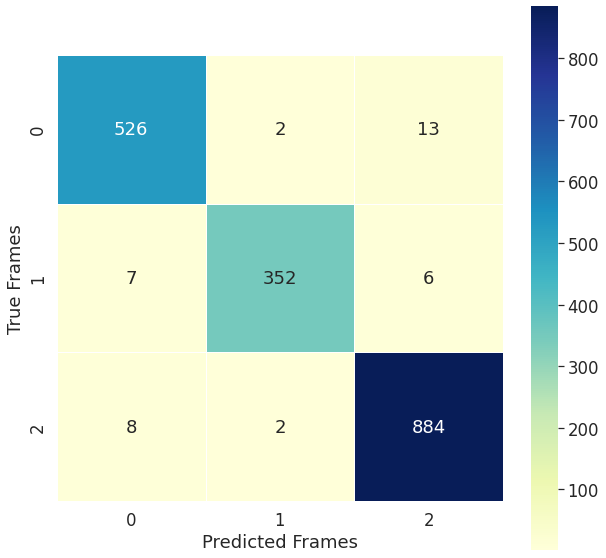

In [61]:
cm = confusion_matrix(y_test, prediction_test)
sns.set(rc={'figure.figsize':(10,10)}, font_scale=1.5)
# plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlOrBr", fmt='d')
plot = sns.heatmap(cm, annot=True, square=True, linewidths=.5, cmap="YlGnBu", fmt='d')
plot.set(xlabel='Predicted Frames', ylabel='True Frames')

In [44]:
sns.set('notebook', 'ticks', font_scale=1.2)
mpl.rcParams['figure.figsize'] = [15,6]

Text(0.5, 1.0, 'Nose tracks across frames')

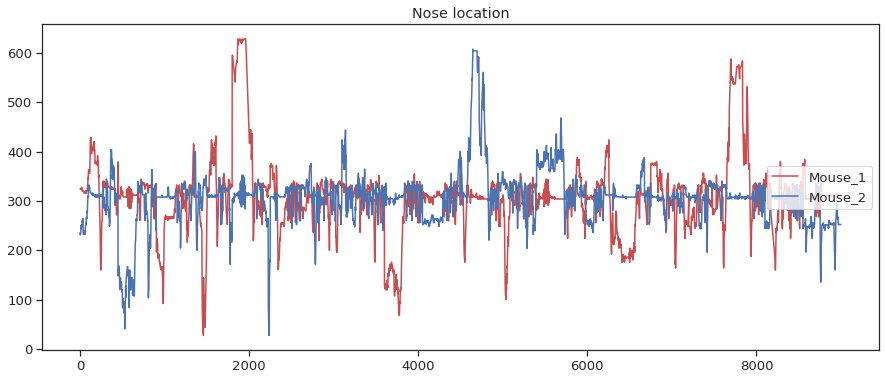

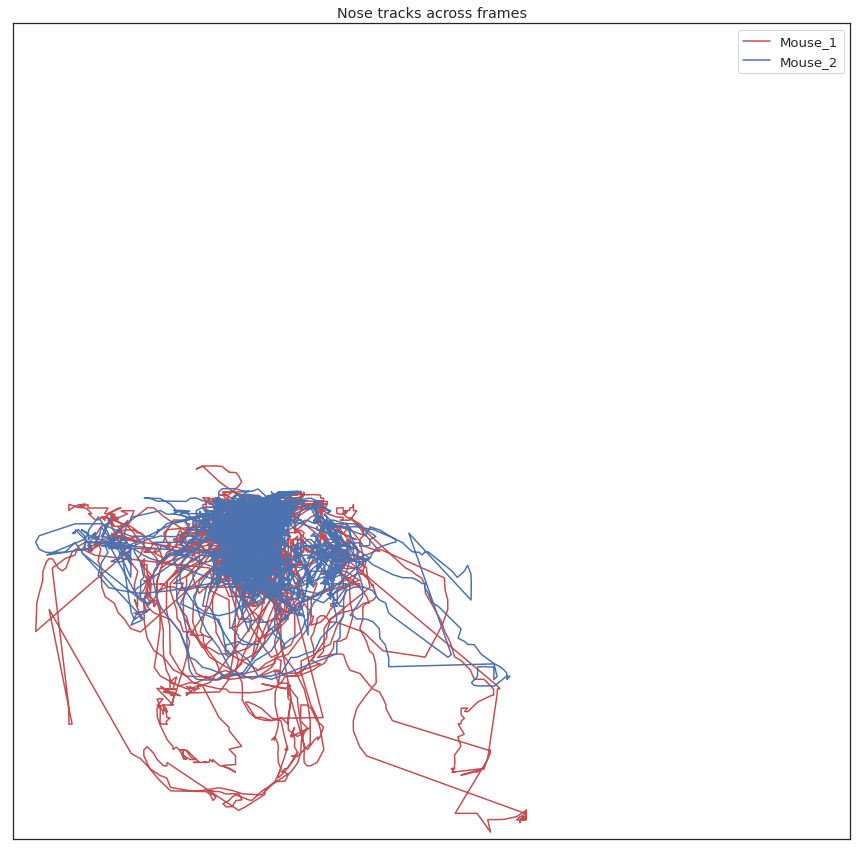

In [45]:
# Figure 1
plt.figure()

plt.plot(nose_loc[:,0,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1], 'b',label='Mouse_2')
# plt.plot(-1*nose_loc[:,1,0], 'r')
# plt.plot(-1*nose_loc[:,1,1], 'b')

plt.legend(loc="center right")

plt.title('Nose location')

# Figure 2
plt.figure(figsize=(15,15))

plt.plot(nose_loc[:,0,0],nose_loc[:,1,0], 'r',label='Mouse_1')
plt.plot(nose_loc[:,0,1],nose_loc[:,1,1], 'b',label='Mouse_2')
plt.legend()

plt.xlim(0,1024)
plt.xticks([])

plt.ylim(0,1024)
plt.yticks([])
plt.title('Nose tracks across frames')

## More advanced visualizations (In Progress)

For some additional analysis, we'll first smooth and differentiate the data with a Savitzky-Golay filter to extract velocities of each joint.

In [46]:
from scipy.signal import savgol_filter

def smooth_diff(node_loc, win=25, poly=3):
    """
    node_loc is a [frames, 2] array
    
    win defines the window to smooth over
    
    poly defines the order of the polynomial
    to fit with
    
    """
    node_loc_vel = np.zeros_like(node_loc)
    
    for c in range(node_loc.shape[-1]):
        node_loc_vel[:, c] = savgol_filter(node_loc[:, c], win, poly, deriv=1)
    
    node_vel = np.linalg.norm(node_loc_vel,axis=1)

    return node_vel

There are two mice. Let's get results for each separately.

In [47]:
thx_vel_mouse1 = smooth_diff(nose_loc[:, :, 0].astype('float64'))
thx_vel_mouse2 = smooth_diff(nose_loc[:, :, 1].astype('float64'))

### Visualizing thorax x-y dynamics and velocity for Mouse_1

Text(0.5, 1.0, 'Velocity')

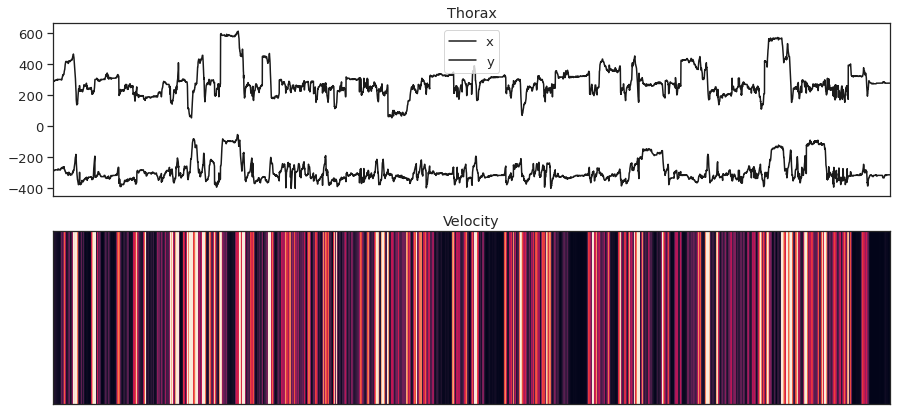

In [48]:
fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(211)
ax1.plot(thorax_loc[:, 0, 0], 'k', label='x')
ax1.plot(-1*thorax_loc[:, 1, 0], 'k', label='y')
ax1.legend()
ax1.set_xticks([])
ax1.set_title('Thorax')

ax2 = fig.add_subplot(212, sharex=ax1)
# Using the Transpose of the Matrix
ax2.imshow(thx_vel_mouse1[:,np.newaxis].T, aspect='auto', vmin=0, vmax=10)
ax2.set_yticks([])
ax2.set_title('Velocity')

### Visualize thorax colored by magnitude of Mouse speed

Text(0.5, 1.0, 'Thorax tracks colored by magnitude of Mouse speed')

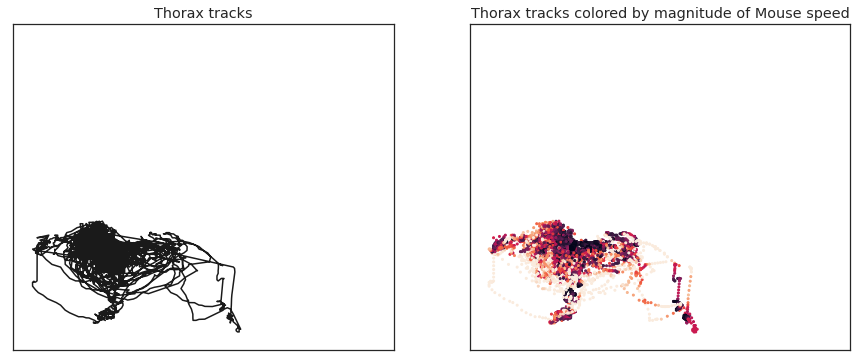

In [49]:
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax1.plot(thorax_loc[:, 0, 0], thorax_loc[:, 1, 0], 'k')
ax1.set_xlim(0,1024)
ax1.set_xticks([])
ax1.set_ylim(0,1024)
ax1.set_yticks([])
ax1.set_title('Thorax tracks')

kp = thx_vel_mouse1 
vmin = 0
vmax = 10

ax2 = fig.add_subplot(122)
ax2.scatter(thorax_loc[:,0,0], thorax_loc[:,1,0], c=kp, s=4, vmin=vmin, vmax=vmax)
ax2.set_xlim(0,1024)
ax2.set_xticks([])
ax2.set_ylim(0,1024)
ax2.set_yticks([])
ax2.set_title('Thorax tracks colored by magnitude of Mouse speed')

### Find covariance in thorax velocities between Mouse_1 and Mouse_2

In [50]:
def corr_roll(datax, datay, win):
    """
    datax, datay are the two timeseries to find correlations between
    
    win sets the number of frames over which the covariance is computed
    
    """
    
    s1 = pd.Series(datax)
    s2 = pd.Series(datay)
    
    return np.array(s2.rolling(win).corr(s1))

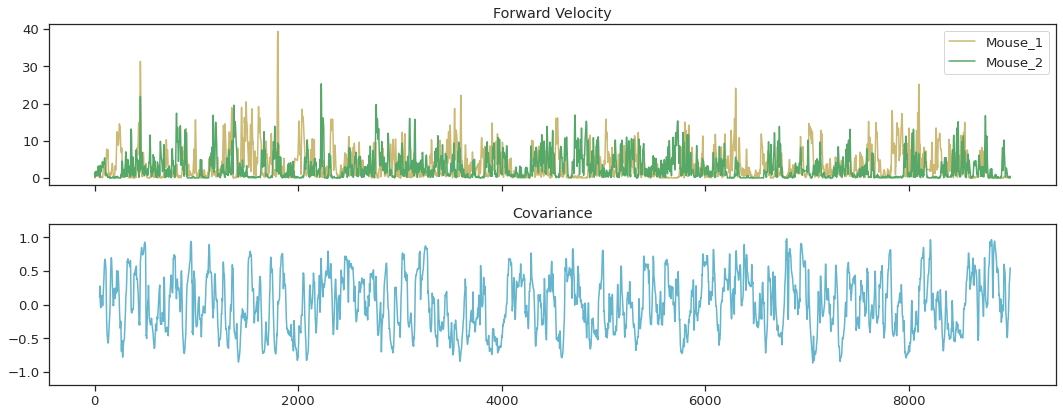

In [51]:
win = 50

cov_vel = corr_roll(thx_vel_mouse1, thx_vel_mouse2,win)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(15,6))
ax[0].plot(thx_vel_mouse1, 'y', label='Mouse_1')
ax[0].plot(thx_vel_mouse2, 'g', label='Mouse_2')
ax[0].legend()
ax[0].set_title('Forward Velocity')

ax[1].plot(cov_vel, 'c', markersize=1)
ax[1].set_ylim(-1.2, 1.2)
ax[1].set_title('Covariance')

fig.tight_layout()

### Todo:
- Use frame rate (30) to correlate have an intuition of which set of frames correspond to which minute/second in the video

## Clustering

For an example of clustering the data, we'll

1. extract joint velocities for each joint,
2. run k-means on the velocities from each frame.


In [52]:
def instance_node_velocities(instance_idx):
    mouse_node_tracks = tracks[:, :, :, instance_idx]
    mouse_node_velocities = np.zeros((n_frames, n_bodyparts))

    for n in range(0, n_bodyparts):
        mouse_node_velocities[:, n] = smooth_diff(mouse_node_tracks[:, n, :])
    
    return mouse_node_velocities

In [53]:
def plot_instance_node_velocities(instance_idx, node_velocities):
    plt.figure(figsize=(20,8))
    plt.imshow(node_velocities.T, aspect='auto', vmin=0, vmax=20, interpolation="nearest")
    plt.xlabel('frames')
    plt.ylabel('nodes')
    plt.yticks(np.arange(n_bodyparts), bodyparts, rotation=20);
    plt.title(f'Mouse {instance_idx} node velocities')

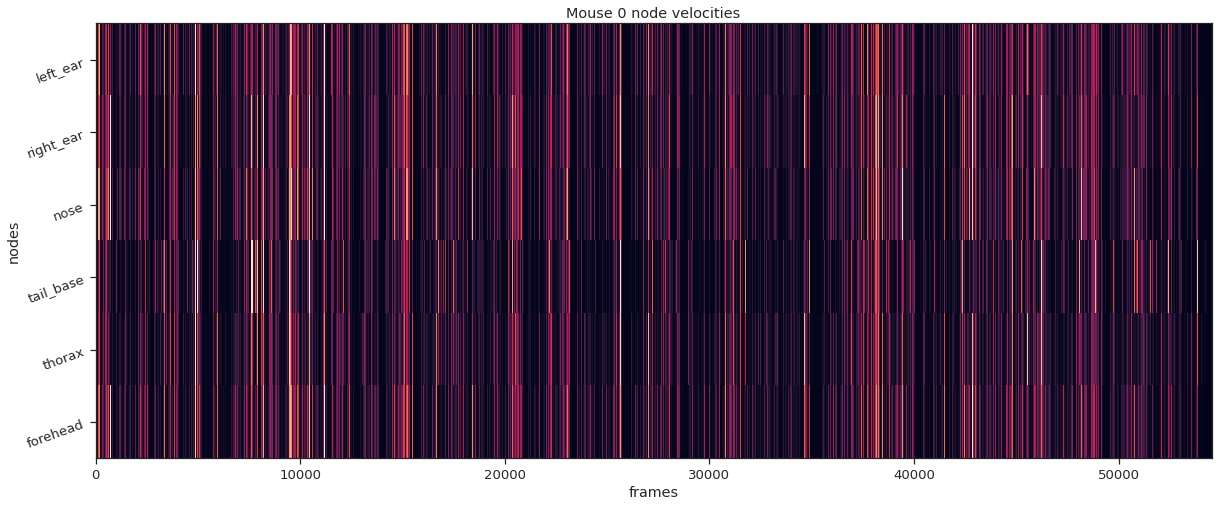

In [54]:
mouse_ID = 0
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

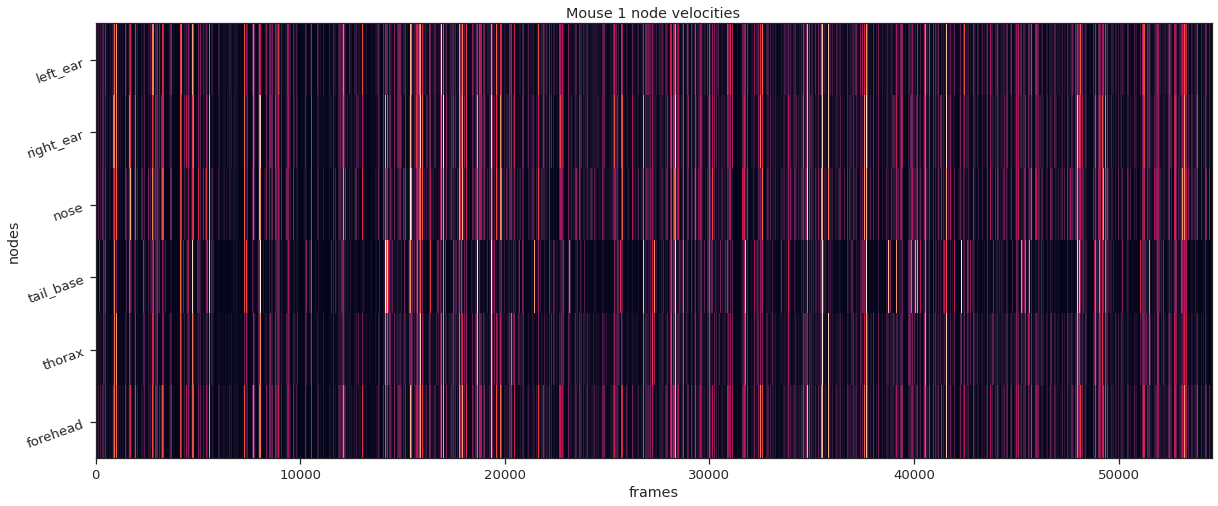

In [55]:
mouse_ID = 1
mouse_node_velocities = instance_node_velocities(mouse_ID)
plot_instance_node_velocities(mouse_ID, mouse_node_velocities)

In [56]:
from sklearn.cluster import KMeans

In [57]:
nstates = 10

km = KMeans(n_clusters=nstates)

labels = km.fit_predict(mouse_node_velocities)

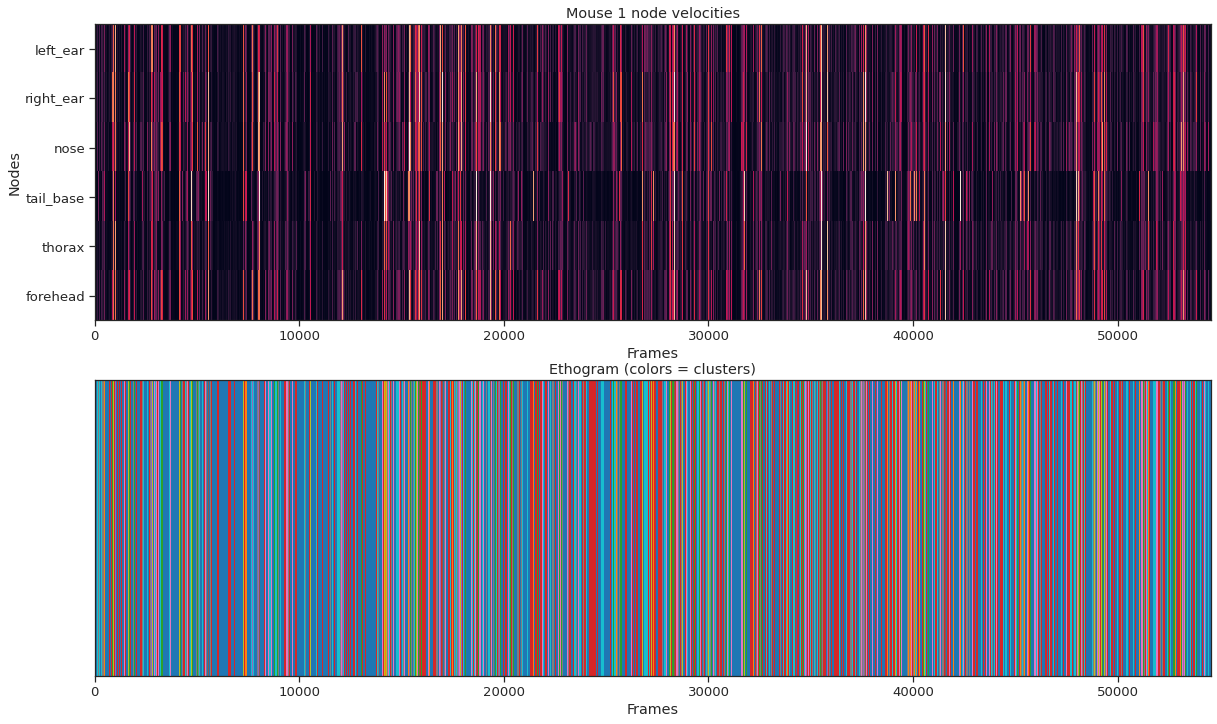

In [58]:
fig = plt.figure(figsize=(20, 12))

ax1 = fig.add_subplot(211)
ax1.imshow(mouse_node_velocities.T, aspect="auto", vmin=0, vmax=20, interpolation="nearest")
ax1.set_xlabel("Frames")
ax1.set_ylabel("Nodes")
ax1.set_yticks(np.arange(n_bodyparts))
ax1.set_yticklabels(bodyparts);
ax1.set_title(f"Mouse {mouse_ID} node velocities")
ax1.set_xlim(0,n_frames)

ax2 = fig.add_subplot(212,sharex=ax1)
ax2.imshow(labels[None, :], aspect="auto", cmap="tab10", interpolation="nearest")
ax2.set_xlabel("Frames")
ax2.set_yticks([])
ax2.set_title("Ethogram (colors = clusters)");